<h1> Problem

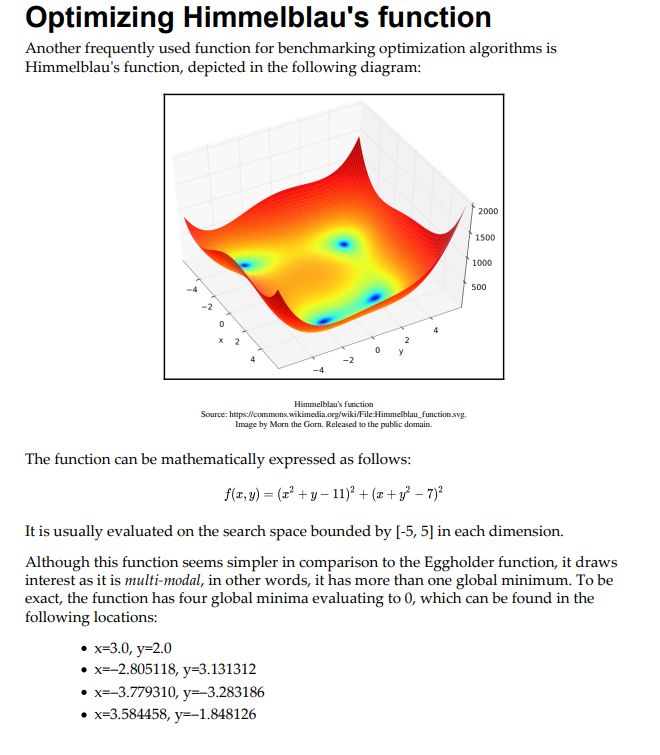

In [1]:
!pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 160 kB 4.1 MB/s 


<h1> Fitness Function and Plotting function

In [2]:
def fitness_function(solution):
  x = solution[0]
  y = solution[1]
  fitness = (x**2 + y - 11)**2 + (x + y**2 - 7)**2
  return fitness,

bests_solutions = [[3.0, 2.0], [-2.805118, 3.131312], [-3.779310, -3.283186], [3.584458, -1.848126]]
# coordenates_divided = list(zip(*bests_solutions)) #[(3.0, -2.805118, -3.77931, 3.584458), (2.0, 3.131312, -3.283186, -1.848126)]

def plotSolutions(solutions):
  import matplotlib.pyplot as plt
  global bests_solutions
  plt.figure(figsize=(13,13))
  plt.scatter(*zip(*bests_solutions), marker="x", color="red")
  plt.scatter(*zip(*solutions), marker="o", color="blue")
  plt.show()


solutions = [[1, 3], [2,4]]
#plotSolutions(solutions)

In [3]:
from deap import creator, base, tools, algorithms
import random
import numpy as np

# STRUCTURE
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("ChromosomeStruct", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()


# GENE, CHROMOSOME, INDIVIDUAL, POPULATION
CHROMOSOME_LENGTH = 2
BOUND_LOW, BOUND_UP = -5, 5 # Defining the limits of function domain
def gene(l, u):
  return random.uniform(l,u)
toolbox.register("Gene", gene, l=BOUND_LOW, u=BOUND_UP)
toolbox.register("Chromosome", tools.initRepeat, creator.ChromosomeStruct, toolbox.Gene, n=CHROMOSOME_LENGTH)
toolbox.register("Individual", toolbox.Chromosome)
toolbox.register("PopulationCreator", tools.initRepeat, list, toolbox.Individual)


# GENETIC OPERATORS
ETA = 20 # Constant that define how much will change in mutation and some kinds of crossover
toolbox.register("evaluate", fitness_function)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, eta=ETA, low=BOUND_LOW, up=BOUND_UP)
toolbox.register("mutate", tools.mutPolynomialBounded, eta=ETA, low=BOUND_LOW, up=BOUND_UP, indpb=1/CHROMOSOME_LENGTH)

  
# STORING THE INFORMATION
stats = tools.Statistics(lambda population: population.fitness.values)
stats.register("max", np.max)
stats.register("min", np.min)
stats.register("mean", np.mean)
hof = tools.HallOfFame(10)


# CONTROL PANEL
POPULATION_SIZE = 1000
PROBABILITY_CROSSOVER = 0.9
PROBABILITY_MUTATION = 0.1
MAX_GENERATIONS = 100 # (stopping condition)
#random.seed(42)


# EVOLVING THE SOLUTION
generationCounter = 0
population = toolbox.PopulationCreator(n=POPULATION_SIZE)
result, logbook = algorithms.eaSimple(population,
                                      toolbox,
                                      cxpb=PROBABILITY_CROSSOVER,
                                      mutpb=PROBABILITY_MUTATION,
                                      ngen=MAX_GENERATIONS,
                                      stats=stats,
                                      halloffame=hof,
                                      verbose=True)

gen	nevals	max    	min     	mean   
0  	1000  	670.338	0.222116	138.193
1  	906   	404.29 	0.188711	69.4011
2  	916   	278.248	0.152212	35.4403
3  	906   	290.957	0.0029738	25.2214
4  	899   	162.562	0.0169319	18.728 
5  	922   	143.464	0.0128032	15.4933
6  	909   	399.652	0.0128032	15.6073
7  	900   	260.497	0.00112987	9.69096
8  	908   	151.635	9.37433e-05	9.40487
9  	890   	136    	6.15637e-05	8.55216
10 	932   	112.268	5.21584e-05	5.68487
11 	911   	133.992	5.43573e-05	4.47623
12 	922   	115.331	1.90792e-05	3.32159
13 	938   	71.5984	5.42487e-07	1.4889 
14 	878   	109.123	1.90792e-05	1.301  
15 	933   	171.275	1.24904e-05	1.60473
16 	915   	115.377	7.90132e-06	0.870211
17 	897   	114.787	2.88687e-06	0.710493
18 	904   	128.814	1.28912e-06	1.27342 
19 	917   	101.661	9.17281e-07	1.13921 
20 	913   	137.97 	2.64e-08   	1.2555  
21 	898   	149.622	2.16957e-08	1.75647 
22 	905   	190.305	1.03175e-09	1.32521 
23 	913   	108.555	4.58413e-10	1.01205 
24 	899   	108.059	4.58413e-10	1.12416

<h1> Plotting results

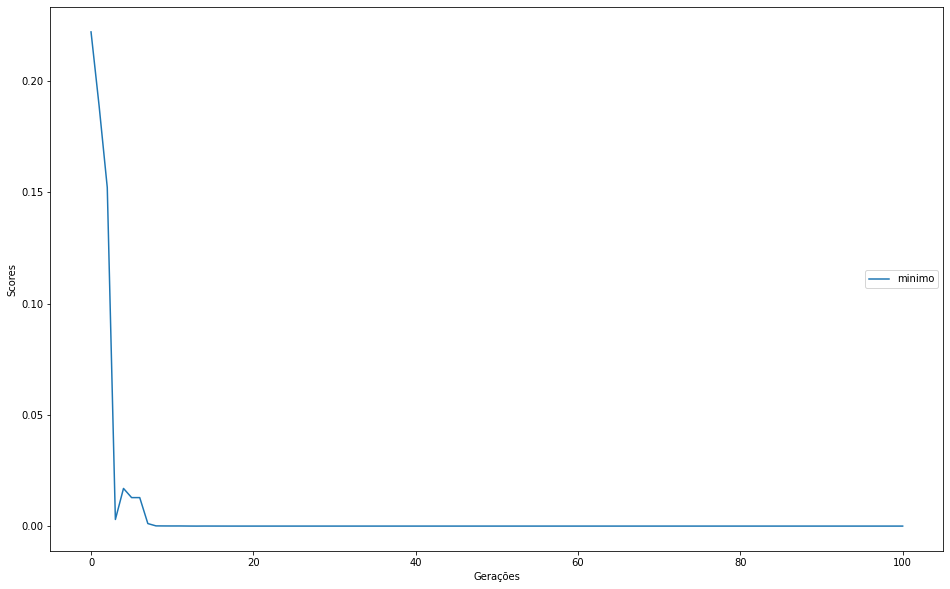

In [4]:
import matplotlib.pyplot as plt

# taking data
y_min = logbook.select("min")
x_gen = logbook.select("gen")


#plotting
plt.figure(figsize=(16,  10))
#plt.plot(x_gen, y_mean, label="media")
plt.plot(x_gen, y_min, label="minimo")
#plt.plot(x_gen, y_max, label="maximo")


plt.xlabel("Gerações")
plt.ylabel("Scores")
plt.legend(loc=5)
plt.show()

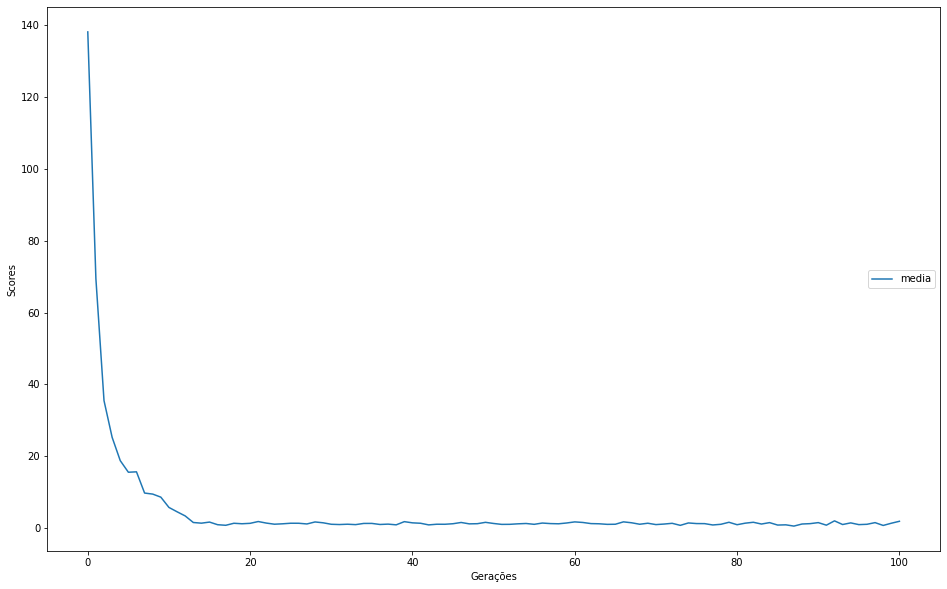

In [5]:
import matplotlib.pyplot as plt

# taking data
y_mean = logbook.select("mean")
#y_max = logbook.select("max")
x_gen = logbook.select("gen")


#plotting
plt.figure(figsize=(16,  10))
plt.plot(x_gen, y_mean, label="media")
#plt.plot(x_gen, y_max, label="maximo")


plt.xlabel("Gerações")
plt.ylabel("Scores")
plt.legend(loc=5)
plt.show()

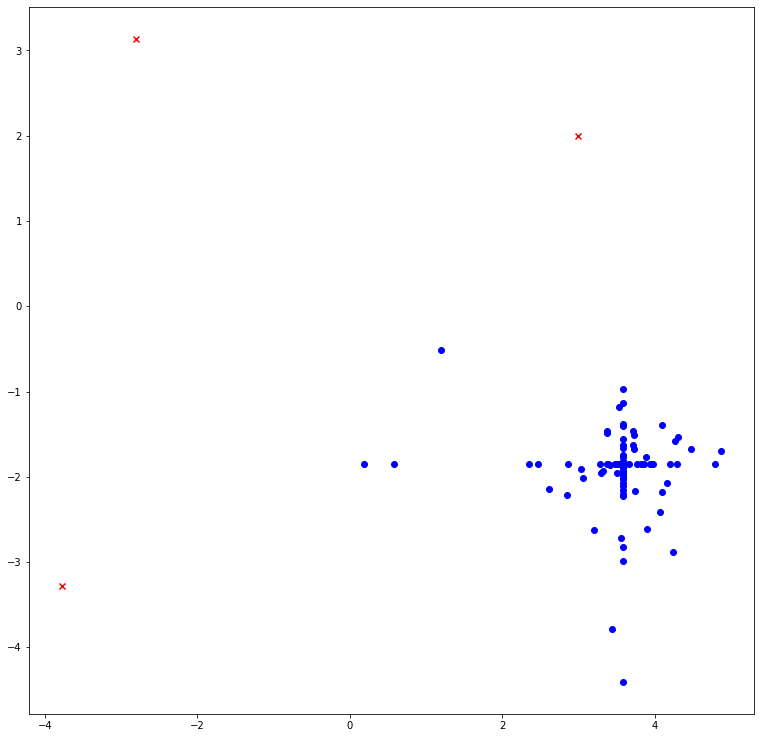

In [6]:
plotSolutions(list(result))

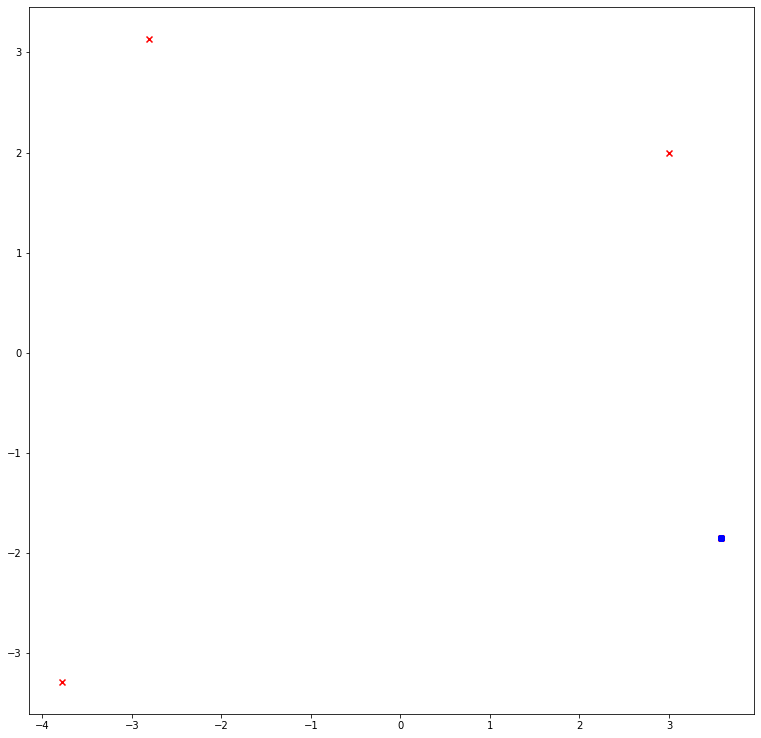

In [7]:
plotSolutions(list(hof))

<h1> Trying to find all best solutions using niches and sharing concepts

In [27]:
# CORE IDEAS
# A niche in genetic algorithms will be a maximum local or global, and every niche has a limited amount of resources.
# In this context, considering that the flow of genetic evolution is acumulate the results in a maximum point we will
# penalize all individuals that is very near each other ( because there is less resources )


# IMPLEMENTATION
# To do this in DEAP framework we will change the selector, because it will take all individuals together and evaluate if
# they are near enough to receive less resourcers ( decreasing fitness scores )
# For this implementation the fitness function need be a function to maximaze then we will change her


# IMPLEMENTATION: NEW SELECTOR
def selTournamentWithSharing(individuals, k, tournsize, fit_attr="fitness"):
  from deap import tools
  from math import sqrt
  global DISTANCE_LIMIT, SHARING_EXTENT


  # Saving the old fitness values
  origFitnesses = [ind.fitness.values[0] for ind in individuals]


  # Changing fitness values based on nearby individuals 
  for i in range(len(individuals)):
    sharingSum = 1    # ( sharingSum )
    x = individuals[i][0]
    y = individuals[i][1]
    for j in range(len(individuals)):
      x2 = individuals[j][0]
      y2 = individuals[j][1]
      if i != j:
        distance = sqrt((x-x2)**2 + (y-y2)**2)
        if distance < DISTANCE_LIMIT:
          sharingSum += (1-distance/(DISTANCE_LIMIT*SHARING_EXTENT))

    individuals[i].fitness.values = origFitnesses[i]/sharingSum,


  # Selecting individuals for the next generations
  selected = tools.selTournament(individuals, k, tournsize, fit_attr)


  # Returning the original fitness
  for i, ind in enumerate(individuals):
    ind.fitness.values = origFitnesses[i],
  
  return selected


In [28]:
def fitness_function(solution):
  x = solution[0]
  y = solution[1]
  fitness = (x**2 + y - 11)**2 + (x + y**2 - 7)**2
  return 2000 - fitness,

In [29]:
from deap import tools
from deap import algorithms

def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
    """This algorithm is similar to DEAP eaSimple() algorithm, with the modification that
    halloffame is used to implement an elitism mechanism. The individuals contained in the
    halloffame are directly injected into the next generation and are not subject to the
    genetic operators of selection, crossover and mutation.
    """
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is None:
        raise ValueError("halloffame parameter must not be empty!")

    halloffame.update(population)
    hof_size = len(halloffame.items) if halloffame.items else 0

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - hof_size)

        # Vary the pool of individuals
        offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # add the best back to population:
        offspring.extend(halloffame.items)

        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # Replace the current population by the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [92]:
from deap import creator, base, tools, algorithms
import random
import numpy as np

# STRUCTURE
creator.create("FitnessMin", base.Fitness, weights=(1.0,))
creator.create("ChromosomeStruct", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()


# GENE, CHROMOSOME, INDIVIDUAL, POPULATION
CHROMOSOME_LENGTH = 2
BOUND_LOW, BOUND_UP = -5, 5 # Defining the limits of function domain
def gene(l, u):
  return random.uniform(l,u)
toolbox.register("Gene", gene, l=BOUND_LOW, u=BOUND_UP)
toolbox.register("Chromosome", tools.initRepeat, creator.ChromosomeStruct, toolbox.Gene, n=CHROMOSOME_LENGTH)
toolbox.register("Individual", toolbox.Chromosome)
toolbox.register("PopulationCreator", tools.initRepeat, list, toolbox.Individual)


# GENETIC OPERATORS
DISTANCE_LIMIT = 0.25    # Distance we will consider that 2 individuals are near each other
SHARING_EXTENT = 20      # Constant the higher it is, the greater the punishment for the individuals nearby
ETA = 15 # Constant that define how much will change in mutation and some kinds of crossover
toolbox.register("evaluate", fitness_function)
toolbox.register("select", selTournamentWithSharing, tournsize=3)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, eta=ETA, low=BOUND_LOW, up=BOUND_UP)
toolbox.register("mutate", tools.mutPolynomialBounded, eta=ETA, low=BOUND_LOW, up=BOUND_UP, indpb=2/CHROMOSOME_LENGTH)

  
# STORING THE INFORMATION
stats = tools.Statistics(lambda population: population.fitness.values)
stats.register("max", np.max)
stats.register("min", np.min)
stats.register("mean", np.mean)
hof = tools.HallOfFame(10)


# CONTROL PANEL
POPULATION_SIZE = 100
PROBABILITY_CROSSOVER = 0.75
PROBABILITY_MUTATION = 0.5
MAX_GENERATIONS = 400 # (stopping condition)
#random.seed(42)


# EVOLVING THE SOLUTION
generationCounter = 0
population = toolbox.PopulationCreator(n=POPULATION_SIZE)
result, logbook = eaSimpleWithElitism(population,
                                      toolbox,
                                      cxpb=PROBABILITY_CROSSOVER,
                                      mutpb=PROBABILITY_MUTATION,
                                      ngen=MAX_GENERATIONS,
                                      stats=stats,
                                      halloffame=hof,
                                      verbose=True)

/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'ChromosomeStruct' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	max    	min    	mean   
0  	100   	1999.04	1626.52	1892.28
1  	83    	1999.04	1694.11	1933.92
2  	80    	1999.21	1720.33	1926.82
3  	67    	1999.21	1702.87	1942.94
4  	82    	1999.21	1795.66	1932.84
5  	73    	1999.96	1772.39	1941.95
6  	76    	1999.96	1763.58	1931.17
7  	83    	1999.96	1771.12	1932.65
8  	78    	1999.96	1613.43	1941.41
9  	78    	1999.96	1655.04	1939.12
10 	70    	1999.96	1606.03	1930.07
11 	80    	1999.96	1606.03	1912.19
12 	83    	1999.96	1612.79	1918.36
13 	75    	1999.96	1675.65	1928.16
14 	77    	1999.96	1618.3 	1942.44
15 	85    	1999.96	1659.92	1934.96
16 	76    	1999.96	1459.79	1923.91
17 	73    	1999.96	1728.32	1949.23
18 	82    	1999.98	1701.8 	1944.18
19 	75    	1999.98	1664.69	1946.66
20 	81    	1999.98	1709.4 	1939.94
21 	76    	1999.98	1642.29	1937.2 
22 	82    	1999.98	1654.68	1936.9 
23 	79    	1999.98	1703.08	1938.79
24 	82    	1999.98	1686.84	1934.21
25 	79    	1999.98	1514.66	1936.79
26 	80    	1999.98	1520.14	1924.15
27 	83    	1999.98	1

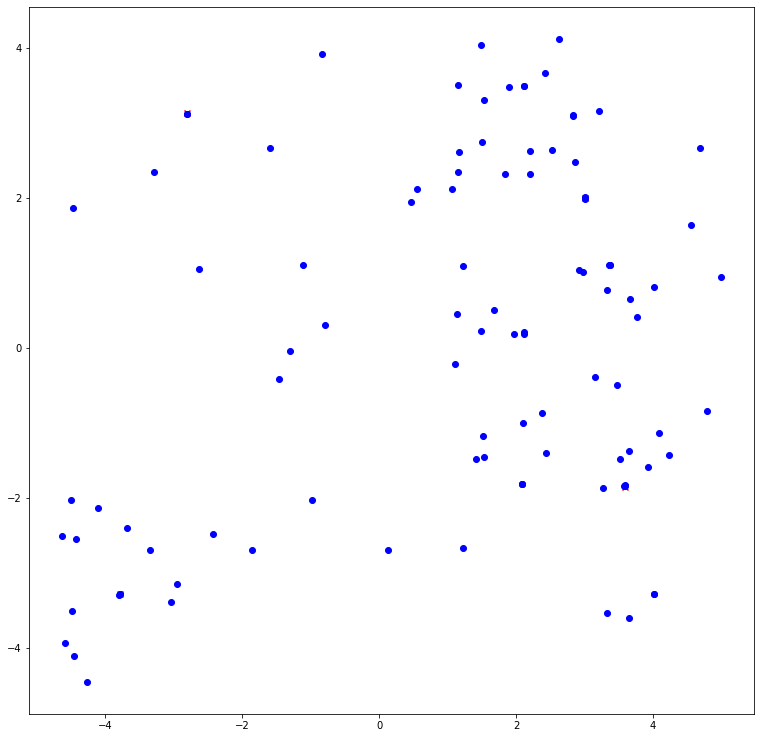

In [93]:
plotSolutions(list(result))

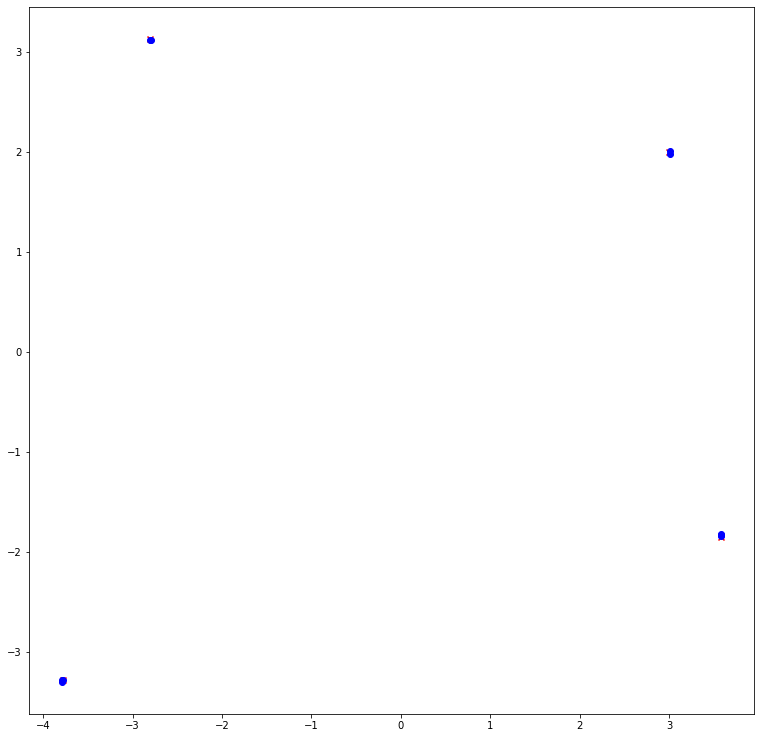

In [94]:
plotSolutions(hof)